In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy.stats as sts
import os
import numpy as np
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr

# Quandl Import
import quandl
from config import api_key

# Import Logistic Regression model from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score


In [2]:
try:
    B_Spread = quandl.get("ML/BEY", authtoken=api_key)
    Treasury_curve = quandl.get("USTREASURY/YIELD", authtoken=api_key)
    SP500 = quandl.get("CHRIS/CME_ES2", authtoken = api_key)
    EM_Yields = quandl.get("ML/EMHYY", authtoken = api_key)
    
    # Saving CSV
    B_Spread.to_csv('B_Spread.csv')
    Treasury_curve.to_csv('Treasury_curve.csv')
    SP500.to_csv('SP500.csv')
    EM_Yields.to_csv('EM_Yields.csv')
    
except Exception as e:
    print(e)

In [3]:
# Importing data 
B_Spread = pd.read_csv('B_Spread.csv')
Treasury_curve = pd.read_csv('Treasury_curve.csv')
SP500 = pd.read_csv('SP500.csv')
EM_Yields = pd.read_csv('EM_Yields.csv')
Nikkei = pd.read_csv('Nikkei.csv')
Ted_Spread = pd.read_csv('Ted_Spread.csv')
USDJPY = pd.read_csv('USDJPY.csv')
VIX = pd.read_csv('VIX.csv')

## SP500 Data

In [4]:
SP500

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,1997-09-09,943.50,951.00,941.50,944.00,NaN,944.00,896.0,273.0
1,1997-09-10,942.75,943.25,917.00,925.00,NaN,925.00,12261.0,382.0
2,1997-09-11,924.00,929.75,910.25,918.25,NaN,918.25,9759.0,2909.0
3,1997-09-12,918.00,936.50,913.50,933.75,NaN,933.75,18496.0,4059.0
4,1997-09-15,933.50,939.75,929.00,931.50,NaN,931.50,11749.0,3818.0
...,...,...,...,...,...,...,...,...,...
5815,2020-07-16,3212.50,3217.00,3178.00,3185.75,-25.00,3183.50,929.0,48166.0
5816,2020-07-17,3185.00,3214.25,3184.25,3203.50,19.75,3203.25,740.0,48111.0
5817,2020-07-20,3204.75,3238.25,3179.75,3233.25,31.25,3234.50,851.0,48216.0
5818,2020-07-21,3235.50,3262.00,3228.00,3239.00,6.00,3240.50,945.0,48251.0


In [5]:
del SP500['Change']
del SP500['Settle']
del SP500['Previous Day Open Interest']
del SP500['Volume']

In [6]:
# Calculations
SP500_Price = pd.DataFrame({'Date':SP500['Date'],
                           'Closing_Price': SP500['Last']
                           })

In [7]:
# Vol calculation
SP500_Price['SP500_Daily_Return'] = SP500_Price['Closing_Price'].pct_change() #Daily return

SP500_Price['SP500_20-day_Vol']= SP500_Price['SP500_Daily_Return'].rolling(20).std() * np.sqrt(252)*100 # 20-day vol
SP500_Price['SP500_50-day_Vol']= SP500_Price['SP500_Daily_Return'].rolling(50).std() * np.sqrt(252)*100 # 50-day vol
SP500_Price['SP500_100-day_Vol']= SP500_Price['SP500_Daily_Return'].rolling(100).std() * np.sqrt(252)*100 # 100-day vol                                                                         

# MA calculation
SP500_Price['SP500_21-day_MA']= SP500_Price['Closing_Price'].rolling(21).mean()
SP500_Price['SP500_55-day_MA']= SP500_Price['Closing_Price'].rolling(55).mean()
SP500_Price['SP500_100-day_MA']= SP500_Price['Closing_Price'].rolling(100).mean()

# Convert to datetime
SP500_Price['Date'] = pd.to_datetime(SP500_Price['Date'])

# Drop N/A
SP500_Price = SP500_Price.dropna()

## Treasury Curve

In [8]:
# Create a new df with the key rates (2,5,10,30 year rates)
Curve_Spreads = pd.DataFrame({'Date':Treasury_curve['Date'],
                             '2Y':Treasury_curve['2 YR'],
                             '5Y':Treasury_curve['5 YR'],
                             '10Y': Treasury_curve['10 YR']
                             })

In [9]:
Curve_Spreads.isnull().sum()

Date    0
2Y      0
5Y      0
10Y     0
dtype: int64

In [10]:


# Adding Curve Spreads
Curve_Spreads['2s5s'] = (Curve_Spreads['5Y'] - Curve_Spreads['2Y'])*100
Curve_Spreads['5s10s'] = (Curve_Spreads['10Y'] - Curve_Spreads['5Y'])*100
Curve_Spreads['2s10s'] = (Curve_Spreads['10Y'] - Curve_Spreads['2Y'])*100

# Spread Returns
Curve_Spreads['2s5s_Return'] = Curve_Spreads['2s5s'].pct_change()
Curve_Spreads['5s10s_Return'] = Curve_Spreads['5s10s'].pct_change()
Curve_Spreads['2s10s_Return'] = Curve_Spreads['2s10s'].pct_change()

# Calculating Spread Volatility - 20 day
Curve_Spreads['2s5s_20-day_Vol']= Curve_Spreads['2s5s_Return'].rolling(20).std() * np.sqrt(252)*100 
Curve_Spreads['5s10s_20-day_Vol']= Curve_Spreads['5s10s_Return'].rolling(20).std() * np.sqrt(252)*100 
Curve_Spreads['2s10s_20-day_Vol']= Curve_Spreads['2s10s_Return'].rolling(20).std() * np.sqrt(252)*100


# MA calculation-----------------------------------------------------------------------------------------------------------
# 2s5s Spread
Curve_Spreads['2s5s_21-day_MA']= Curve_Spreads['2s5s'].rolling(21).mean()
Curve_Spreads['2s5s_55-day_MA']= Curve_Spreads['2s5s'].rolling(55).mean()
Curve_Spreads['2s5s_100-day_MA']= Curve_Spreads['2s5s'].rolling(100).mean()

# 5s10s Spread
Curve_Spreads['5s10s_21-day_MA']= Curve_Spreads['5s10s'].rolling(21).mean()
Curve_Spreads['5s10s_55-day_MA']= Curve_Spreads['5s10s'].rolling(55).mean()
Curve_Spreads['5s10s_100-day_MA']= Curve_Spreads['5s10s'].rolling(100).mean()

# 2s10s Spread
Curve_Spreads['2s10s_21-day_MA']= Curve_Spreads['2s10s'].rolling(21).mean()
Curve_Spreads['2s10s_55-day_MA']= Curve_Spreads['2s10s'].rolling(55).mean()
Curve_Spreads['2s10s_100-day_MA']= Curve_Spreads['2s10s'].rolling(100).mean()

# Converting to datetime
Curve_Spreads['Date'] = pd.to_datetime(Curve_Spreads['Date'])

# Drop N/A
Curve_Spreads = Curve_Spreads.dropna()

In [11]:
# Deleting Spread returns
del Curve_Spreads['2s10s_Return']
del Curve_Spreads['5s10s_Return']
del Curve_Spreads['2s5s_Return']

In [12]:
all_logistic_df = pd.merge(Curve_Spreads,SP500_Price,on=['Date'])

In [13]:
all_logistic_df

,Date,2Y,5Y,10Y,2s5s,5s10s,2s10s,2s5s_20-day_Vol,5s10s_20-day_Vol,2s10s_20-day_Vol,...,2s10s_55-day_MA,2s10s_100-day_MA,Closing_Price,SP500_Daily_Return,SP500_20-day_Vol,SP500_50-day_Vol,SP500_100-day_Vol,SP500_21-day_MA,SP500_55-day_MA,SP500_100-day_MA
0,1998-01-30,5.32,5.39,5.53,7.0,14.0,21.0,1239.089561,334.055916,452.444246,...,13.963636,20.17,995.25,-0.004252,19.745629,17.906344,23.453145,979.678571,973.009091,967.1825
1,1998-02-02,5.36,5.43,5.57,7.0,14.0,21.0,1239.676595,334.055916,448.119507,...,14.018182,19.99,1016.50,0.021351,21.057299,18.455638,23.442655,981.011905,974.804545,968.0975
2,1998-02-03,5.34,5.41,5.56,7.0,15.0,22.0,1166.101999,295.521379,415.185463,...,14.072727,19.86,1020.50,0.003935,21.074817,18.159598,23.408605,982.297619,976.468182,969.1200
3,1998-02-04,5.32,5.41,5.57,9.0,16.0,25.0,396.956669,277.616941,245.539942,...,14.218182,19.75,1021.00,0.000490,20.312998,18.109067,23.272723,983.488095,977.895455,969.9925
4,1998-02-05,5.36,5.46,5.62,10.0,16.0,26.0,368.532960,267.521792,228.187924,...,14.400000,19.64,1016.75,-0.004163,20.428176,17.483172,23.280924,985.130952,978.927273,970.8450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4759,2020-07-16,0.16,0.28,0.62,12.0,34.0,46.0,152.705618,72.309518,76.766546,...,51.509091,46.59,3185.75,-0.007864,19.355684,23.388472,49.410970,3110.702381,3028.009091,2884.1875
4760,2020-07-17,0.14,0.29,0.64,15.0,35.0,50.0,177.867137,68.712470,81.607639,...,51.636364,46.96,3203.50,0.005572,19.360563,23.266032,49.214722,3115.321429,3032.613636,2884.8500
4761,2020-07-20,0.16,0.29,0.62,13.0,33.0,46.0,182.971751,71.445815,86.163198,...,51.672727,47.25,3233.25,0.009287,18.673330,23.079259,49.188655,3121.702381,3039.127273,2886.1975
4762,2020-07-21,0.14,0.27,0.61,13.0,34.0,47.0,181.150022,72.513417,86.243019,...,51.727273,47.53,3239.00,0.001778,18.191934,22.853414,48.527670,3130.333333,3046.945455,2889.1275


## EM Bond Yields

In [14]:
EM_Yields.rename(columns={'DATE':'Date'}, inplace=True)
EM_Yields.rename(columns={'BAMLEMHBHYCRPIEY':'EM_High_Yield'}, inplace=True)

# Calculating the returns
EM_Yields['EM Returns'] = EM_Yields['EM_High_Yield'].pct_change()

# Calculating the 20, 50 and 100 day vol
EM_Yields['EM_Bonds_20-day_Vol']= EM_Yields['EM Returns'].rolling(20).std() * np.sqrt(252)*100 
EM_Yields['EM_Bonds_50-day_Vol']= EM_Yields['EM Returns'].rolling(50).std() * np.sqrt(252)*100 
EM_Yields['EM_Bonds_100-day_Vol']= EM_Yields['EM Returns'].rolling(100).std() * np.sqrt(252)*100 

# Calculating the 21, 55 and 100 day MA
EM_Yields['EM_Bonds_21-day_MA']= EM_Yields['EM_High_Yield'].rolling(21).mean() 
EM_Yields['EM_Bonds_55-day_MA']= EM_Yields['EM_High_Yield'].rolling(55).mean() 
EM_Yields['EM_Bonds_100-day_MA']= EM_Yields['EM_High_Yield'].rolling(100).mean()

# Converting to datetime
EM_Yields['Date'] = pd.to_datetime(EM_Yields['Date'])



In [15]:
# Deleting EM Returns Column
del EM_Yields['EM Returns']

# Drop N/A
EM_Yields = EM_Yields.dropna()

In [16]:
# Merging EM_Yields and all_logistic_df
all_logistic_df = pd.merge(all_logistic_df,EM_Yields,on=['Date'])

## VIX

In [17]:
# Formatting the dates 
VIX['Date'] = pd.to_datetime(VIX['Date'])

In [18]:
# Calculating the MAs for VIX
VIX['VIX_21-day_MA'] = VIX['VIX'].rolling(21).mean()
VIX['VIX_55-day_MA'] = VIX['VIX'].rolling(55).mean()
VIX['VIX_100-day_MA'] = VIX['VIX'].rolling(100).mean()

In [19]:
VIX = VIX.dropna()

In [20]:
# Merging VIX and all_logistic_df
all_logistic_df = pd.merge(all_logistic_df,VIX,on=['Date'])

## USD/JPY

In [21]:
USDJPY.rename(columns={'DATE':'Date'},inplace=True)
USDJPY.rename(columns={'DEXJPUS':'USDJPY'},inplace=True)

# Converting to datetime
USDJPY['Date'] = pd.to_datetime(USDJPY['Date'])

# Calculating the returns for VIX
USDJPY['USD/JPY_Returns'] = USDJPY['USDJPY'].pct_change()

#Calculating the MAs for VIX
USDJPY['USDJPY_21-day_MA'] = USDJPY['USDJPY'].rolling(21).mean()
USDJPY['USDJPY_55-day_MA'] = USDJPY['USDJPY'].rolling(55).mean()
USDJPY['USDJPY_100-day_MA'] = USDJPY['USDJPY'].rolling(100).mean()

In [22]:
del USDJPY['USD/JPY_Returns']

In [23]:
USDJPY = USDJPY.dropna()

In [24]:
all_logistic_df = pd.merge(all_logistic_df,USDJPY,on=['Date'])

## Ted Spread

In [25]:
Ted_Spread.rename(columns={'Value':'Ted_Spread'},inplace=True)

# Converting to datetime
Ted_Spread['Date'] = pd.to_datetime(Ted_Spread['Date'])

# Calculating the returns for Ted Spread
Ted_Spread['Ted_Spread_Return'] = Ted_Spread['Ted_Spread'].pct_change()

Ted_Spread['VIX_21-day_MA'] = Ted_Spread['Ted_Spread'].rolling(21).mean()
Ted_Spread['VIX_55-day_MA'] = Ted_Spread['Ted_Spread'].rolling(55).mean()
Ted_Spread['VIX_100-day_MA'] = Ted_Spread['Ted_Spread'].rolling(100).mean()

In [26]:
del Ted_Spread['Ted_Spread_Return']

In [27]:
Ted_Spread = Ted_Spread.dropna()

In [28]:
all_logistic_df = pd.merge(all_logistic_df,Ted_Spread,on=['Date'])

## Credit Spreads

In [29]:
B_Spread.rename(columns={'DATE':'Date'}, inplace=True)
B_Spread.rename(columns={'BAMLH0A2HYBEY':'B_Spread'}, inplace=True)

In [30]:
Five_year = pd.DataFrame({'Date':Treasury_curve['Date'],
                         'Five_year':Treasury_curve['5 YR']
                         })

In [31]:
Credit_spreads = pd.merge(B_Spread,Five_year,on=['Date'])

In [32]:
Credit_spreads['B_UST_Spread'] = Credit_spreads['B_Spread'] - Credit_spreads['Five_year']

In [33]:
Credit_spreads['Credit_21-day_MA'] = Credit_spreads['B_UST_Spread'].rolling(21).mean()
Credit_spreads['Credit_55-day_MA'] = Credit_spreads['B_UST_Spread'].rolling(55).mean()
Credit_spreads['Credit_100-day_MA'] = Credit_spreads['B_UST_Spread'].rolling(100).mean()

In [34]:
Credit_spreads = Credit_spreads.dropna()

In [35]:
Credit_spreads['Date'] = pd.to_datetime(Credit_spreads['Date'])

In [36]:
all_logistic_df = pd.merge(all_logistic_df,Credit_spreads,on=['Date'])

In [37]:
all_logistic_df.columns

Index(['Date', '2Y', '5Y', '10Y', '2s5s', '5s10s', '2s10s', '2s5s_20-day_Vol',
       '5s10s_20-day_Vol', '2s10s_20-day_Vol', '2s5s_21-day_MA',
       '2s5s_55-day_MA', '2s5s_100-day_MA', '5s10s_21-day_MA',
       '5s10s_55-day_MA', '5s10s_100-day_MA', '2s10s_21-day_MA',
       '2s10s_55-day_MA', '2s10s_100-day_MA', 'Closing_Price',
       'SP500_Daily_Return', 'SP500_20-day_Vol', 'SP500_50-day_Vol',
       'SP500_100-day_Vol', 'SP500_21-day_MA', 'SP500_55-day_MA',
       'SP500_100-day_MA', 'EM_High_Yield', 'EM_Bonds_20-day_Vol',
       'EM_Bonds_50-day_Vol', 'EM_Bonds_100-day_Vol', 'EM_Bonds_21-day_MA',
       'EM_Bonds_55-day_MA', 'EM_Bonds_100-day_MA', 'VIX', 'VIX_21-day_MA_x',
       'VIX_55-day_MA_x', 'VIX_100-day_MA_x', 'USDJPY', 'USDJPY_21-day_MA',
       'USDJPY_55-day_MA', 'USDJPY_100-day_MA', 'Ted_Spread',
       'VIX_21-day_MA_y', 'VIX_55-day_MA_y', 'VIX_100-day_MA_y', 'B_Spread',
       'Five_year', 'B_UST_Spread', 'Credit_21-day_MA', 'Credit_55-day_MA',
       'Credit_100

## Nikkei

In [41]:
# Formatting date
Nikkei['Date'] = pd.to_datetime(Nikkei['Date'])

# Calculating Nikkei Returns
Nikkei['Nikkei_Returns'] = Nikkei['Value'].pct_change()

# Calculating Nikkei Historical Vol
Nikkei['Nikkei_20-day_Vol']= Nikkei['Nikkei_Returns'].rolling(20).std() * np.sqrt(252)*100 
Nikkei['Nikkei_50-day_Vol']= Nikkei['Nikkei_Returns'].rolling(50).std() * np.sqrt(252)*100 
Nikkei['Nikkei_100-day_Vol']= Nikkei['Nikkei_Returns'].rolling(100).std() * np.sqrt(252)*100 

# Calculating the MAs for Nikkei
Nikkei['Nikkei_21-day_MA'] = Nikkei['Value'].rolling(21).mean()
Nikkei['Nikkei_55-day_MA'] = Nikkei['Value'].rolling(55).mean()
Nikkei['Nikkei_100-day_MA'] = Nikkei['Value'].rolling(100).mean()

In [43]:
Nikkei = Nikkei.dropna()

In [45]:
all_logistic_df = pd.merge(all_logistic_df,Nikkei,on=['Date'])

In [49]:
all_logistic_df.rename(columns={'Value':'Nikkei'}, inplace=True)

In [50]:
all_logistic_df.to_csv('all_logistic_df.csv')

In [60]:
all_logistic_df.set_index('Date', inplace=True)

In [61]:
all_logistic_df

,2Y,5Y,10Y,2s5s,5s10s,2s10s,2s5s_20-day_Vol,5s10s_20-day_Vol,2s10s_20-day_Vol,2s5s_21-day_MA,...,Credit_55-day_MA,Credit_100-day_MA,Nikkei,Nikkei_Returns,Nikkei_20-day_Vol,Nikkei_50-day_Vol,Nikkei_100-day_Vol,Nikkei_21-day_MA,Nikkei_55-day_MA,Nikkei_100-day_MA
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-19,5.37,5.54,5.60,17.0,6.0,23.0,324.107388,273.998384,219.897511,16.333333,...,5.210545,5.5353,16128.18,-0.015291,22.064530,28.013079,23.617317,16764.658095,16104.888364,15143.1466
1999-05-20,5.35,5.53,5.60,18.0,7.0,25.0,315.791506,280.992814,218.752590,16.809524,...,5.196727,5.5231,16199.99,0.004452,21.924723,28.012493,23.621846,16739.558571,16136.334545,15163.8766
1999-05-21,5.30,5.46,5.52,16.0,6.0,22.0,319.754666,282.713143,222.002822,17.095238,...,5.182545,5.5108,16292.98,0.005740,21.834043,25.848340,23.625809,16712.958571,16171.342545,15184.8635
1999-05-24,5.28,5.43,5.50,15.0,7.0,22.0,318.437351,282.084433,215.333160,17.285714,...,5.168909,5.4988,16390.49,0.005985,21.963360,25.768330,23.625835,16699.448095,16210.774182,15207.2389
1999-05-25,5.30,5.44,5.49,14.0,5.0,19.0,308.724438,297.053799,220.846472,17.476190,...,5.153636,5.4856,16214.23,-0.010754,21.876590,25.542630,23.282561,16676.453810,16252.468182,15231.5867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.17,0.30,0.64,13.0,34.0,47.0,214.805928,111.389388,124.781086,16.190476,...,7.360364,7.2139,22512.08,0.011334,26.840810,25.835371,35.825841,22490.822381,20932.780364,20854.6714
2020-06-29,0.16,0.28,0.64,12.0,36.0,48.0,201.611135,113.261270,123.014236,16.095238,...,7.323273,7.2431,21995.04,-0.022967,28.061627,25.704380,35.907650,22496.400952,20988.141455,20844.8443
2020-06-30,0.16,0.29,0.66,13.0,37.0,50.0,199.957865,113.238719,123.718705,15.904762,...,7.289818,7.2723,22288.14,0.013326,28.144572,25.769589,35.936263,22507.150952,21041.503273,20835.6739


## Logistic Regression

In [62]:
y = np.where(all_logistic_df['Nikkei'].shift(-1) > all_logistic_df['Nikkei'],1,-1)
y

array([ 1,  1,  1, ..., -1,  1, -1])

In [63]:
X = all_logistic_df.iloc[:,:60]

## Splitting Data Sets

In [64]:
split = int(0.8*len(all_logistic_df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [77]:
X_test

,2Y,5Y,10Y,2s5s,5s10s,2s10s,2s5s_20-day_Vol,5s10s_20-day_Vol,2s10s_20-day_Vol,2s5s_21-day_MA,...,Credit_55-day_MA,Credit_100-day_MA,Nikkei,Nikkei_Returns,Nikkei_20-day_Vol,Nikkei_50-day_Vol,Nikkei_100-day_Vol,Nikkei_21-day_MA,Nikkei_55-day_MA,Nikkei_100-day_MA
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-15,0.82,1.61,2.28,79.0,67.0,146.0,32.371122,45.888304,30.819357,80.380952,...,5.518000,5.1916,18026.48,0.003383,45.805793,31.336067,24.614686,18591.505714,19737.876364,19936.7120
2015-09-16,0.82,1.62,2.30,80.0,68.0,148.0,32.888263,44.884665,30.808769,80.095238,...,5.529818,5.2004,18171.60,0.008050,45.910668,31.230028,24.579257,18478.035714,19700.346727,19917.0890
2015-09-17,0.70,1.50,2.21,80.0,71.0,151.0,30.719414,45.886899,31.406891,79.809524,...,5.543818,5.2109,18432.27,0.014345,46.376899,30.709147,24.692118,18392.780476,19665.854909,19899.5352
2015-09-18,0.69,1.45,2.13,76.0,68.0,144.0,34.385857,44.943492,33.462798,79.476190,...,5.561818,5.2225,18070.21,-0.019643,45.753705,30.939655,24.845090,18299.289524,19621.267818,19880.0369
2015-09-24,0.67,1.44,2.13,77.0,69.0,146.0,42.006388,33.422145,31.372228,78.809524,...,5.630364,5.2744,17571.83,-0.027580,43.893017,31.478609,25.203223,18210.527619,19567.304909,19855.9220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.17,0.30,0.64,13.0,34.0,47.0,214.805928,111.389388,124.781086,16.190476,...,7.360364,7.2139,22512.08,0.011334,26.840810,25.835371,35.825841,22490.822381,20932.780364,20854.6714
2020-06-29,0.16,0.28,0.64,12.0,36.0,48.0,201.611135,113.261270,123.014236,16.095238,...,7.323273,7.2431,21995.04,-0.022967,28.061627,25.704380,35.907650,22496.400952,20988.141455,20844.8443
2020-06-30,0.16,0.29,0.66,13.0,37.0,50.0,199.957865,113.238719,123.718705,15.904762,...,7.289818,7.2723,22288.14,0.013326,28.144572,25.769589,35.936263,22507.150952,21041.503273,20835.6739


## Train/Fit Model

In [66]:
model = LogisticRegression()
model = model.fit (X_train,y_train)
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

C:\Users\bnjau\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,0,1
0,2Y,[-0.07972083231492758]
1,5Y,[-0.07949377130266762]
2,10Y,[-0.07967524661038285]
3,2s5s,[0.02270610120529592]
4,5s10s,[-0.01814753072925166]
5,2s10s,[0.00455857047562925]
6,2s5s_20-day_Vol,[0.00033220544766508845]
7,5s10s_20-day_Vol,[0.0005180406994892937]
8,2s10s_20-day_Vol,[-0.00015647690107984508]
9,2s5s_21-day_MA,[-0.027455997007494282]


In [67]:
print(f"Training Data Score: {model.score(X_train, y_train)}")
print(f"Testing Data Score: {model.score(X_test, y_test)}")

Training Data Score: 0.6154975051364837
Testing Data Score: 0.5845070422535211


## Making predictions

In [71]:
predictions = model.predict(X_test)
print(f"First 20 Predictions:   {predictions[:20]}")
print(f"First 20 Actual labels: {y_test[:20].tolist()}")

First 20 Predictions:   [ 1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1]
First 20 Actual labels: [1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1]


In [72]:
Predictions_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
Predictions_df

,Prediction,Actual
0,1,1
1,1,1
2,1,-1
3,1,-1
4,1,1
...,...,...
847,-1,-1
848,1,1
849,1,-1
850,1,1


## Model Metrics
• Classification Report / Confusion Matrix / Accuracy Score

In [73]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions)

0.5845070422535211

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.61      0.28      0.39       395
           1       0.58      0.85      0.69       457

    accuracy                           0.58       852
   macro avg       0.60      0.56      0.54       852
weighted avg       0.59      0.58      0.55       852



In [75]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

array([[111, 284],
       [ 70, 387]], dtype=int64)

In [76]:
(111+387) / (111+70+387+284)

0.5845070422535211

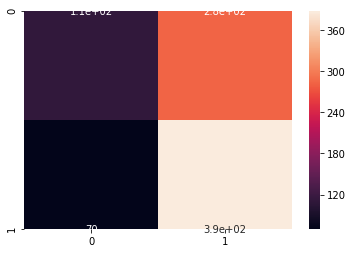

In [80]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test,predictions)


sns.heatmap(cf_matrix, annot=True)

In [38]:
logistic_reg_inputs = pd.read_csv('final_model_df.csv')

# Delete unncessary column 
del logistic_reg_inputs['Unnamed: 0']

In [39]:
logistic_reg_inputs['Date'] = pd.to_datetime(logistic_reg_inputs['Date'])